# Advanced event handling for FMUs for Model Exchange

Class **IncrementalFMU** offers the possibility to combine the integration of an FMU for ModelExchange (FMI Version 1.0 and 2.0) with advanced event handling. It implements a lookahead mechanism, where predictions of the FMU’s state are incrementally computed and stored and the occurence of future events can be predicted (within a certain time horizon). This functionality is especially useful when utilizing the FMUs in event-base simulations.

For more details please also take a look at [this plublication](http://dx.doi.org/10.1109/MSCPES.2015.7115397 "Using FMI components in discrete event systems").

## Loading the library and extracting an FMU

Load the FMI++ library into Python.

In [1]:
import fmipp

Specify the FMU's model name.

In [2]:
model_name = 'zigzag'

Specify the absolute path of the FMU. In this example, the FMU is supposed to be in the same directory as this notebook.

In [3]:
import os
work_dir = os.getcwd() # get current working directory (contains 'zigzag.fmu')
path_to_fmu = os.path.join( work_dir, 'data', 'win', model_name + '.fmu' ) # path to FMU

Extract the FMU to the current work directory. The return value is the URI to the folder containing the unzipped FMU.

In [4]:
uri_to_extracted_fmu = fmipp.extractFMU( path_to_fmu, work_dir )
print( 'URI of extracted FMU: {}'.format( uri_to_extracted_fmu ) )

directory already exists: C:\Users\widle\Desktop\Modelica 2019\tutorial\demo\zigzag
URI of extracted FMU: file:///C:/Users/widle/Desktop/Modelica%202019/tutorial/demo/zigzag


## Loading, instantiating and initialising the FMU

Specify the configuration parameters for class IncrementalFMU.

In [5]:
logging_on = False              # turn logging on/off
event_search_precision = 1e-2   # set precision for event detection
integrator_type = fmipp.bdf     # use Backward Differentiation Formula from CVODE
#integrator_type = fmipp.rk     # alternatively, use Runge-Kutta for integration

Create smart wrapper for FMU.

In [6]:
fmu = fmipp.IncrementalFMU( uri_to_extracted_fmu, model_name, logging_on, event_search_precision, integrator_type )

Specify parameters that should be initialized. Construct string array for initial parameter names and values.

In [7]:
n_init = 1 # number of parameters to be initialized
k = 1.0    # slope

init_vars = fmipp.new_string_array( n_init )    # create new array of strings, containing parameter names
fmipp.string_array_setitem( init_vars, 0, 'k' ) # set 1st element (index 0) of array 'init_vars'

init_vals = fmipp.new_double_array( n_init )  # create new array of doubles, containing parameter values
fmipp.double_array_setitem( init_vals, 0, k ) # set 1st element (index 0) of array 'init_vals'

Specify number of real outputs and construct string array with output names.

In [8]:
n_real_outputs = 2
output_names = fmipp.new_string_array( n_real_outputs )
fmipp.string_array_setitem( output_names, 0, 'x' )      # set 1st element (index 0) of array 'output_names'
fmipp.string_array_setitem( output_names, 1, 'derx' ) # set 2nd element (index 1) of array 'output_names'

Specifiy number of real inputs and construct string array with input names.

In [9]:
n_real_inputs = 1
input_names = fmipp.new_string_array( n_real_inputs ) # create new array of strings, containing variable names
fmipp.string_array_setitem( input_names, 0, 'k' )     # set 1st element (index 0) of array 'input_names'

Define real inputs and outputs.

In [10]:
fmu.defineRealOutputs( output_names, n_real_outputs )
fmu.defineRealInputs( input_names, n_real_inputs )

Specify lookahead horizon, the step size for storing predictions and the internal intergrator step size.

In [11]:
horizon = 0.3
prediction_step_size = horizon / 5.
integrator_step_size = prediction_step_size / 10.

## Run a simulation with random input events

Define start/stop time of simulation and default step size.

In [12]:
sim_start = 0
sim_stop = 10
sim_step = horizon

Initialize the FMU and check the status.

In [13]:
status = fmu.init( 'zigzag1', init_vars, init_vals, n_init, sim_start, horizon, prediction_step_size, integrator_step_size )
assert status == 1 # check status

Simulate the FMU and store the results.

In [14]:
time = sim_start
next = sim_start

real_input_vals = fmipp.new_double_array( n_real_inputs )

x_sim = []
derx_sim = []
t_sim = []

import random
random.seed( 123 )

while ( time + sim_step < sim_stop ):
    oldnext = next
    
    if ( random.random() < 0.2 ):  # random event
        # the random event occurs before the next scheduled update
        event_time = time + min( sim_step, next - time ) * random.random();

        # the event changes the value of 'k'
        k = max( 1, k + random.choice( [ 1, -2 ] ) )
        fmipp.double_array_setitem( real_input_vals, 0, k )
        print( 'change value of k to {:.0f} at time {:.2f}'.format( k, event_time ) )

        # sync the FMU: advance the FMU's state only to the time of the 
        # random event, then set the new inputs and compute the next
        # scheduled synchronization time.
        next = fmu.sync( time, event_time, real_input_vals )
        time = event_time
    else:
        # sync the FMU: advance the FMU's state to the next scheduled
        # synchronization time.
        next = fmu.sync( time, min( time + sim_step, next ) )
        time = min( time + sim_step, oldnext )
    
    real_output_vals = fmu.getRealOutputs()  # retrieve outputs
    x = fmipp.double_array_getitem( real_output_vals, 0 )  # retrieve x
    derx = fmipp.double_array_getitem( real_output_vals, 1 )  # retrieve derx

    t_sim.append( time )
    x_sim.append( x )
    derx_sim.append( derx )


change value of k to 1 at time 0.00
change value of k to 1 at time 1.64
change value of k to 2 at time 2.21
change value of k to 3 at time 2.83
change value of k to 4 at time 3.16
change value of k to 2 at time 4.17
change value of k to 3 at time 8.30
change value of k to 1 at time 8.56
change value of k to 1 at time 8.67


Plot the results.

<IPython.core.display.Javascript object>


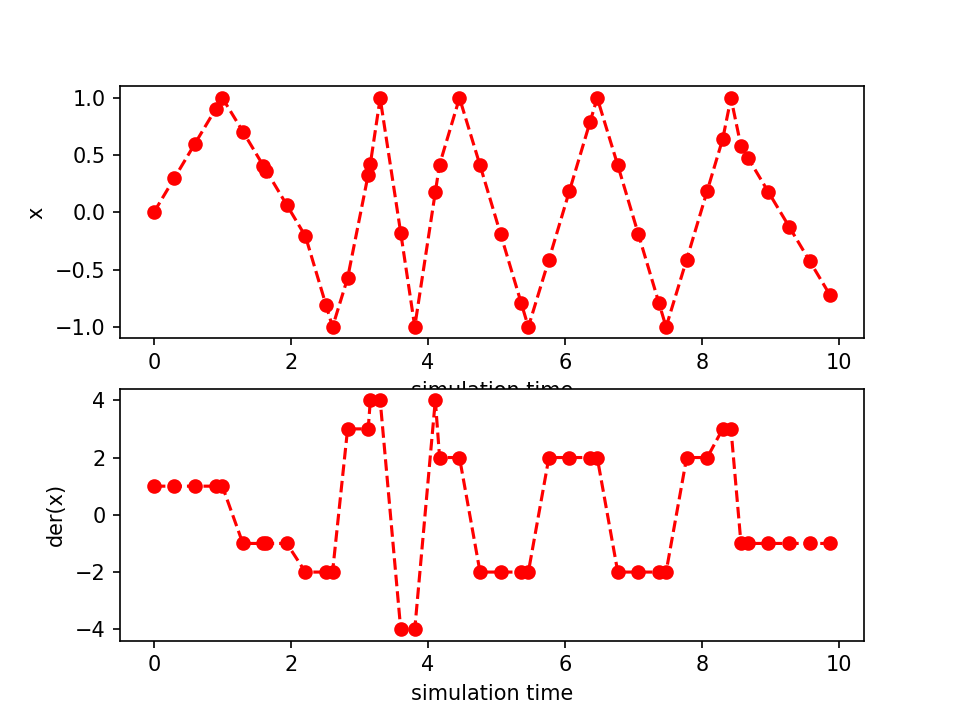

In [15]:
%matplotlib notebook
import matplotlib.pyplot as plotter

plotter.subplot(211)
plotter.plot( t_sim, x_sim, 'ro', t_sim, x_sim, 'r--' )
plotter.xlabel( 'simulation time' )
plotter.ylabel( 'x' )

plotter.subplot(212)
plotter.plot( t_sim, derx_sim, 'ro', t_sim, derx_sim, 'r--' )
plotter.xlabel( 'simulation time' )
plotter.ylabel( 'der(x)' )

plotter.show()

Done.